In [1]:
import numpy as np

%matplotlib notebook
%autosave 1

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from paglm.chebyshev import compute_chebyshev
from paglm.model import *
# import seaborn as sns
from scipy.linalg import hankel

Autosaving every 1 seconds


26


<IPython.core.display.Javascript object>


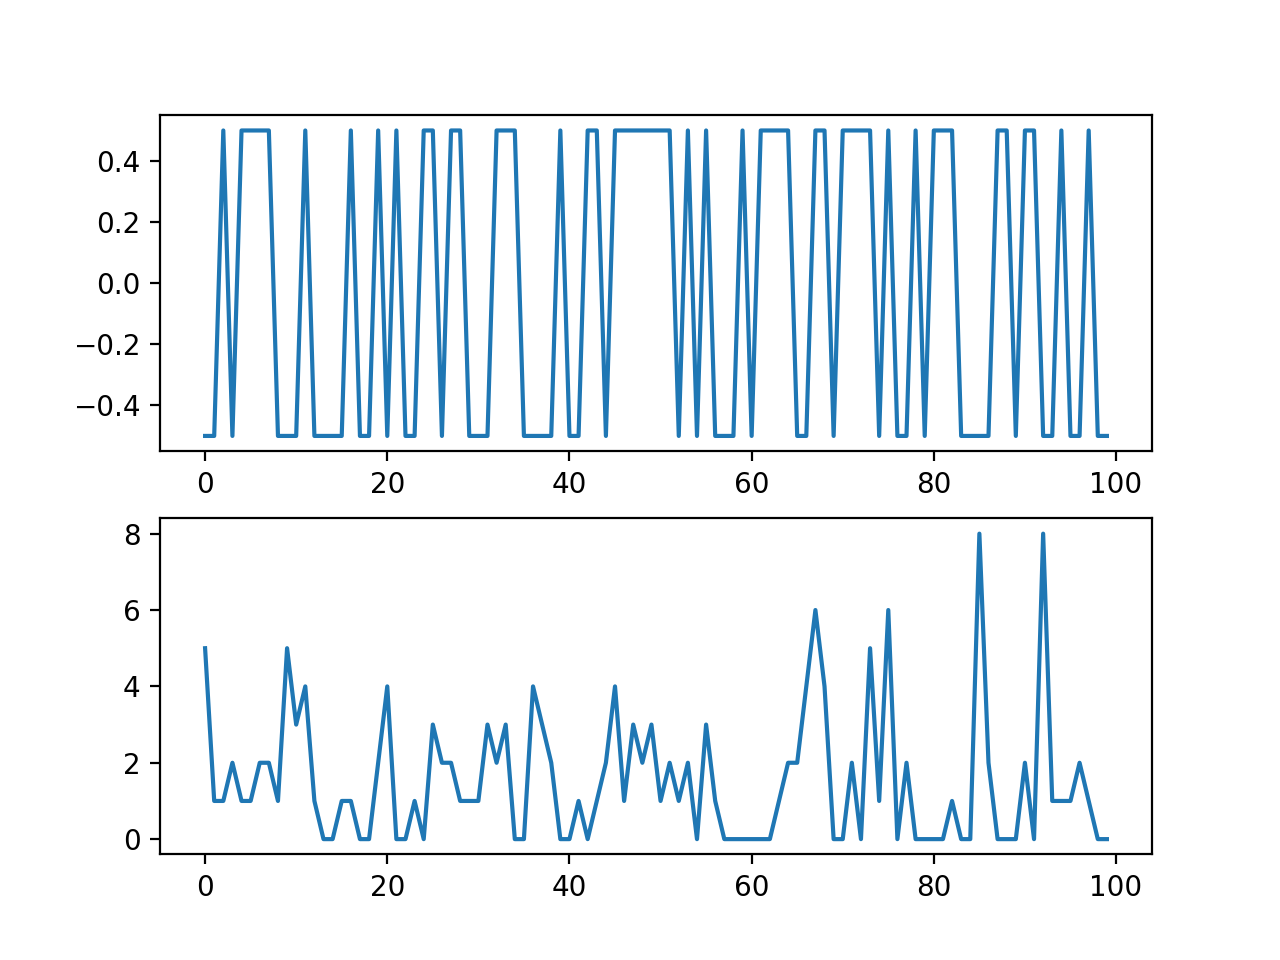

In [2]:
# simulate Poisson GLM with autoregressive stimulus filter
w = np.array([ 1.0, 0.0, 0.0, 0.0, -0.01368046, -0.01986828,
 -0.03867417, -0.05218188, -0.10044614, -0.12434759, -0.19540891, -0.23327453,
 -0.32255702, -0.40001292, -0.46124429, -0.46235415, -0.43928836, -0.52066692,
 -0.58597496, -0.15804368,  1.2849799,   1.91338741,  1.10402054,  0.23188751,
  0.00331092, -0.0111924, ])

D = np.shape(w)[0]
print(D)

T = 20000 # time bins

# binary stimulus
x = np.random.randint(0,2,[T,])-0.5
# x = np.random.randint(0,2,[T,])

# Gaussian stimulus
# x = 0.3*np.random.randn(T)

# spiking bin size
dtSp = 1.0 

# generate design matrix 
X = hankel(np.append(np.zeros(D-2),x[:T-D+2]),x[T-D+1:])
X = np.concatenate((np.ones([T,1]),X),axis=1)

# define softplus
def softplus(x):
#     if x > 80:
#         return x
#     else:
#         return np.log1p(np.exp(x))
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x,0)

# def safe_softplus(x):
#     return np.log1p(np.exp(-np.abs(x))) + np.max(x,0)

# generate spikes 
y = np.random.poisson(softplus(X@w)*dtSp)

# look at data
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[:100])
plt.subplot(2,1,2)
plt.plot(y[:100])

In [3]:
# statistics of data
print(np.mean(y/dtSp))
print(np.std(y/dtSp))
4+2.5

1.50255
1.5766399390793067


6.5

In [4]:
# prior
lambda_ridge = np.power(2.0,4)
lambda_ridge = 0.0
Cinv = lambda_ridge*np.eye(D)
Cinv[0,0] = 0.0 # no prior on bias

In [5]:
# fit MAP
from scipy.optimize import minimize
res = minimize(lambda w: -poisson_log_like(w,y,X,dtSp,softplus,Cinv), np.zeros([D,]),method='L-BFGS-B', tol=1e-4,options={'disp': True})
w_map = res.x

In [6]:
# int_mean_std = np.array([np.mean(y/dtSp)-np.std(y/dtSp),np.mean(y/dtSp)+np.std(y/dtSp)])
# int_mean_std

NameError: name 'int_mean_std' is not defined

interval:  [-1  4]


<IPython.core.display.Javascript object>


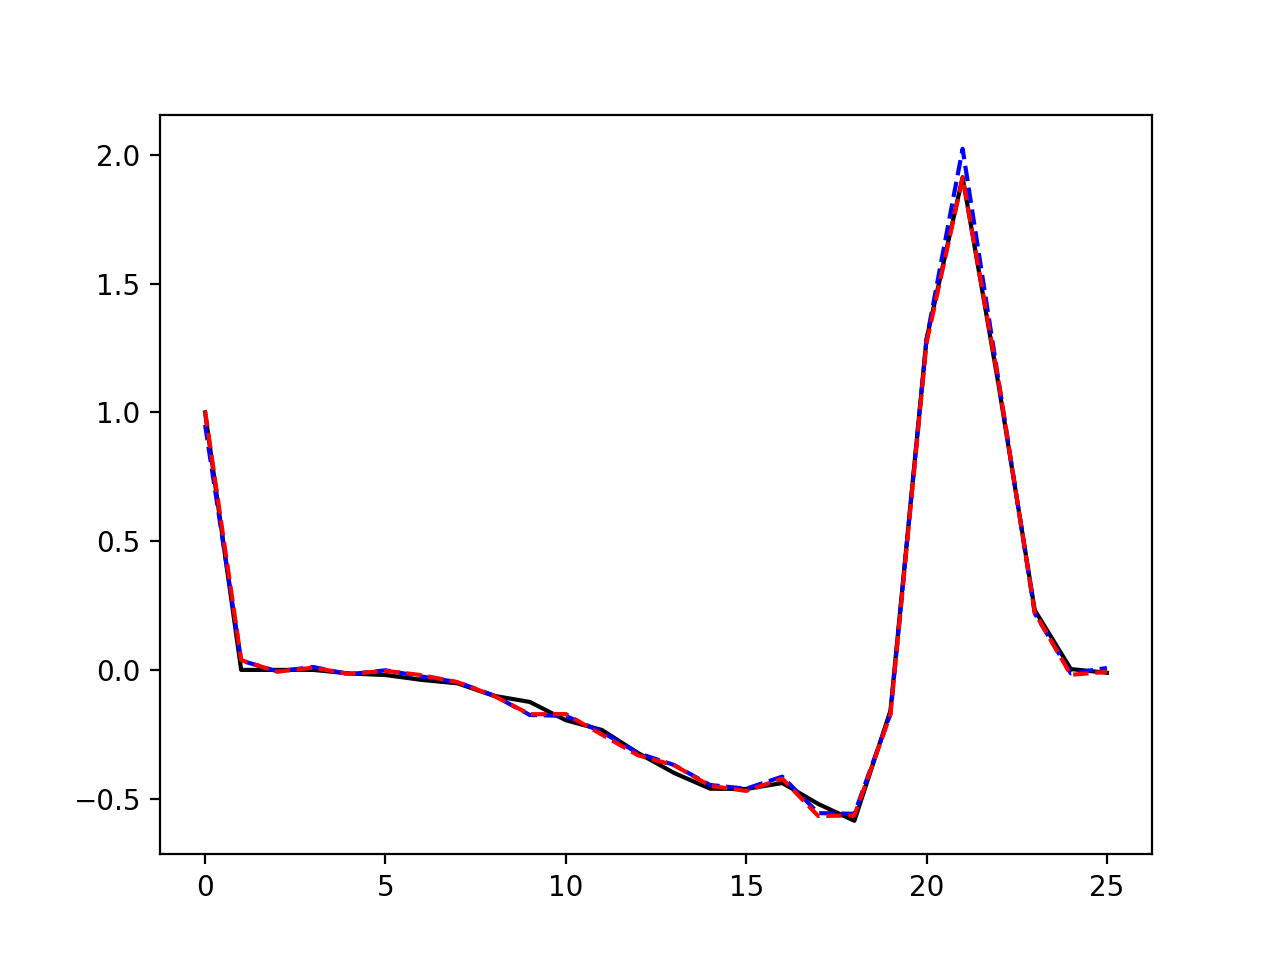

In [6]:
int_mean_std = np.array([np.mean(y/dtSp)-2*np.std(y/dtSp),np.mean(y/dtSp)+2*np.std(y/dtSp)])
intervals = [int_mean_std,np.array([-1,4])]
# intervals = [np.array([1.5,6.5]),np.array([0.0,8.0])]

# build sufficient statistics
suff, X_sub, y_sub = process_data(X,y,subset_frac=0.1)

# fit model
w_paglm, interval = fit_paglm(softplus,suff,dtSp,intervals,Cinv=Cinv,X_sub=X_sub,y_sub=y_sub)

print('interval: ', interval)
plt.figure()
plt.plot(w,'k')
plt.plot(w_paglm,'b--')
plt.plot(w_map,'r--')

<IPython.core.display.Javascript object>


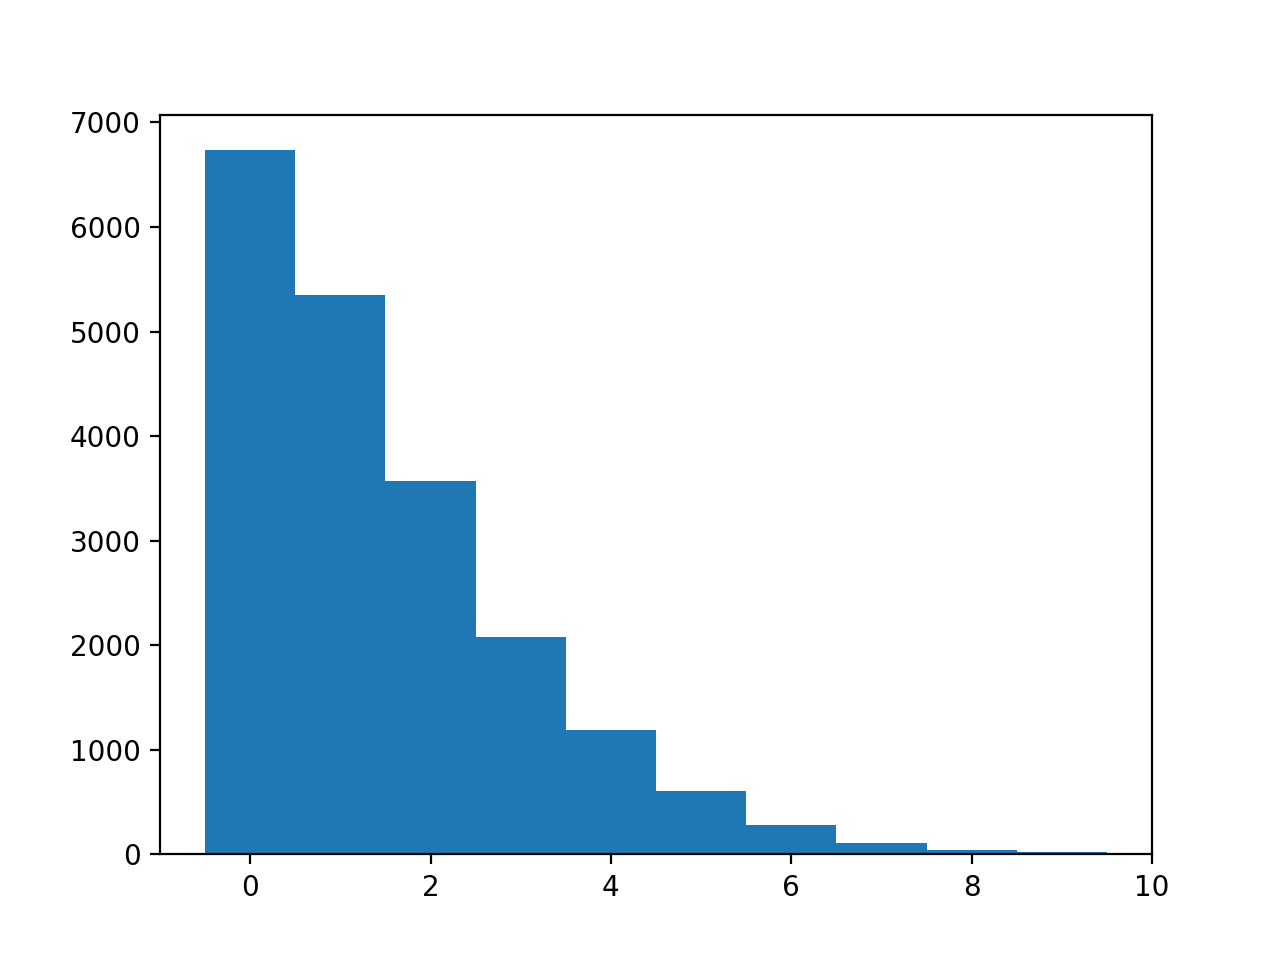

(array([6732., 5353., 3573., 2080., 1192.,  604.,  283.,  111.,   43.,
          19.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

In [44]:
plt.figure()
plt.hist(y/dtSp,np.arange(-0.5,10.5,1))